## Create a Spark Session

In [1]:
import findspark
findspark.init('/afs/cern.ch/work/m/migliori/public/spark2.3.1/')

In [2]:
application_name = 'dist-keras-notebook'
master = "local[8]"

In [3]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .appName("dist-keras")\
        .config("spark.master", master)\
        .config("spark.driver.memory", "32G")\
        .config("spark.pyspark.python",
                "/afs/cern.ch/work/m/migliori/public/anaconda2/bin/python")\
        .config("spark.local.dir", "/local1/matteo")\
        .config("spark.sql.execution.arrow.enabled", "true")\
        .getOrCreate()

In [4]:
spark

## Load the dataframe

In [5]:
HLF_dataset = spark.read.format("parquet") \
        .load("../more_data.parquet") \
        .select(['hfeatures', 'label'])
                
HLF_dataset.count()

58878

In [6]:
HLF_dataset.show(5)

+--------------------+-----+
|           hfeatures|label|
+--------------------+-----+
|[125.582424163818...|    1|
|[453.637893676757...|    1|
|[137.816619873046...|    1|
|[404.660964965820...|    1|
|[0.0,53.927665710...|    1|
+--------------------+-----+
only showing top 5 rows



## Prepare the features

In [7]:
## Converte hfeatures in vector dense 
## The function used to convert returns a list but we need vector dense
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf

vector_dense_udf = udf(lambda r : Vectors.dense(r),VectorUDT())
HLF_dataset = HLF_dataset.withColumn('dense_features',vector_dense_udf('hfeatures'))

In [8]:
## Create train and test dataframes
train, test = HLF_dataset.randomSplit([0.8, 0.2])

In [9]:
print('Events for the training {}'.format(train.count()))
print('Events for the validation {}'.format(test.count()))

Events for the training 47267
Events for the validation 11611


In [10]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoderEstimator
from pyspark.ml.feature import MinMaxScaler

## One-Hot-Encode
encoder = OneHotEncoderEstimator(inputCols=["label"],
                                 outputCols=["encoded_label"],
                                 dropLast=False)

## Scale feature vector
scaler = MinMaxScaler(inputCol="dense_features",
                      outputCol="features")

pipeline = Pipeline(stages=[encoder, scaler])

fitted_pipeline = pipeline.fit(train)

In [11]:
## Transform train and test
train = fitted_pipeline.transform(train)
test = fitted_pipeline.transform(test)

train = train.select(['features', 'label', 'encoded_label'])
test = test.select(['features', 'label', 'encoded_label'])
#train = train.selectExpr('features', 'encoded_label as label')
#test = test.selectExpr('features', 'encoded_label as label')

In [12]:
from pyspark.sql.functions import rand 
train = train.orderBy(rand())
train.show(10)

+--------------------+-----+-------------+
|            features|label|encoded_label|
+--------------------+-----+-------------+
|[0.01388285326242...|    2|(3,[2],[1.0])|
|[0.0,0.0249722765...|    2|(3,[2],[1.0])|
|[0.0,0.0720812149...|    2|(3,[2],[1.0])|
|[0.0,0.0771809819...|    2|(3,[2],[1.0])|
|[0.0,0.0442846326...|    2|(3,[2],[1.0])|
|[0.06555730518374...|    1|(3,[1],[1.0])|
|[0.03646417135310...|    2|(3,[2],[1.0])|
|[0.10730394549989...|    1|(3,[1],[1.0])|
|[0.0,0.0690675525...|    2|(3,[2],[1.0])|
|[0.02176358160914...|    1|(3,[1],[1.0])|
+--------------------+-----+-------------+
only showing top 10 rows



In [13]:
train.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1|22817|
|    2|23891|
|    0|  375|
+-----+-----+



As we can see the training dataset in highly unbalanced. 

## Build the Keras model

In [14]:
from keras.optimizers import adam
from keras.models import Sequential
from keras.layers.core import Dense, Activation

Using TensorFlow backend.


In [46]:
model = Sequential()
model.add(Dense(50, input_shape=(14,), activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 50)                750       
_________________________________________________________________
dense_6 (Dense)              (None, 20)                1020      
_________________________________________________________________
dense_7 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 33        
Total params: 2,013
Trainable params: 2,013
Non-trainable params: 0
_________________________________________________________________


## Distributed-Keras trainer

In [16]:
from distkeras.trainers import * 
from distkeras.predictors import *
from distkeras.utils import *
from distkeras.workers import *

In [17]:
optimizer = 'adam'
loss = 'categorical_crossentropy'

num_epochs = 50 
batch_size = 128

## set the number of workers
num_workers = 5

In [18]:
trainer = AEASGD(keras_model=model, worker_optimizer=optimizer,
                 loss=loss, num_workers=num_workers, batch_size=batch_size,
                 features_col="features", label_col="encoded_label", num_epoch=num_epochs,
                 communication_window=32, rho=5.0, learning_rate=0.1,
                 master_port=5500)
trainer.set_parallelism_factor(1)

In [19]:
trained_model = trainer.train(train)

In [20]:
print('Training time using AEASGD: {} min' \
      .format(int(trainer.get_training_time()/60)))

Training time using AEASGD: 1 min


We can also try to use another trainer (ADAG): 

In [21]:
trainer_adag = ADAG(keras_model=model, worker_optimizer=optimizer, loss=loss,
                    metrics=["accuracy"], num_workers=num_workers, batch_size=batch_size,
                    features_col="features", label_col="encoded_label",
                    num_epoch=num_epochs, communication_window=12,
                    master_port=5600)
trainer_adag.set_parallelism_factor(1)

In [22]:
trained_model_adag = trainer_adag.train(train)

In [23]:
print('Training time using ADAG: {} min' \
      .format(int(trainer_adag.get_training_time()/60)))

Training time using ADAG: 3 min


Dynamic SGD

In [24]:
trainer_dsgd = DynSGD(keras_model=model, worker_optimizer=optimizer, loss=loss,
                      metrics=["accuracy"], num_workers=num_workers, batch_size=batch_size,
                      features_col="features", label_col="encoded_label", num_epoch=num_epochs,
                      communication_window=10, master_port=5700)
trainer_dsgd.set_parallelism_factor(1)

In [25]:
trained_model_dsgd = trainer_dsgd.train(train)

Not executed


In [26]:
print('Training time using DynSGD: {} min' \
      .format(int(trainer_dsgd.get_training_time()/60)))

Training time using DynSGD: 3 min


###  Plot workers iterations and Loss

In [23]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib notebook

In [28]:
worker_id = []
worker_iterations = []
worker_trainer = []

trainers_list = [trainer, trainer_adag, trainer_dsgd]
trainers_name = ['AEASGD', 'ADAG', 'DynSGD']

for t, t_name in zip(trainers_list, trainers_name):
    for i in range(t.get_num_workers()):
        worker_id.append(i)
        worker_iterations.append(len(t.get_executor_history(i)))
        worker_trainer.append(t_name)
        
trainer_dataframe = pd.DataFrame({'worker_id':worker_id,
                                  'worker_iterations':worker_iterations,
                                  'trainer':worker_trainer})
trainer_dataframe.head()

,trainer,worker_id,worker_iterations
0,AEASGD,0,3650
1,AEASGD,1,3650
2,AEASGD,2,3650
3,AEASGD,3,3650
4,AEASGD,4,3650


<IPython.core.display.Javascript object>


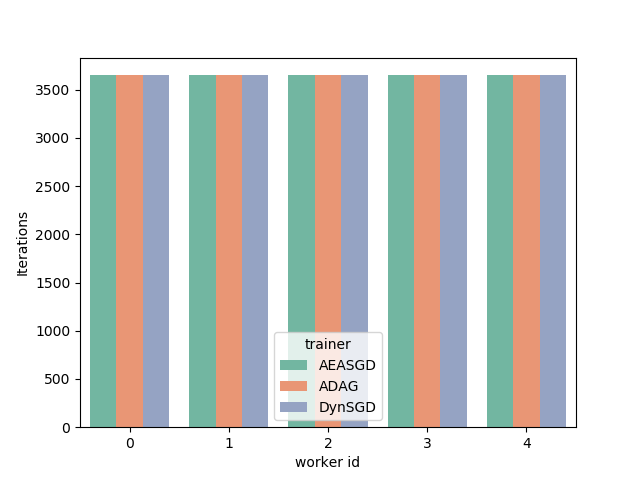

In [41]:
%matplotlib notebook 
plt.figure()
sns.barplot(x='worker_id', y='worker_iterations', hue='trainer',
              data=trainer_dataframe, palette="Set2")
plt.xlabel('worker id')
plt.ylabel('Iterations')
plt.show()

In [30]:
def compute_trainer_metrics(trainer):
    
    ## Get the history of each executor and find the max number of iterations
    num_workers = trainer.get_num_workers()
    max_iterations = 0
    
    history = []
    
    for i in range(num_workers):
        history.append(trainer.get_executor_history(i))
        if history[i][-1]['iteration']>max_iterations:
            max_iterations = history[i][-1]['iteration']
            
    iteration = []
    avg_loss = []
    std_loss = []

    ## Average the losses of batch_size iterations
    batch_loss = []
    batch_std = []
    
    for i in range(max_iterations):
        loss_i = [h[i]['history'][0] for h in history if i<len(h)]
        batch_loss.append(np.mean(loss_i))
        batch_std.append(np.std(loss_i))
    
        if (i%100==0) or (i==max_iterations-1):
            iteration.append(i)
            avg_loss.append(np.mean(batch_loss))
            std_loss.append(np.mean(batch_std))
            batch_loss = []
            batch_std = []
    
    iteration = np.asarray(iteration)
    loss = np.asarray(avg_loss)
    error = np.asarray(std_loss)
    
    return iteration, loss, error

In [31]:
x, y, err = compute_trainer_metrics(trainer)

In [32]:
x_adag, y_adag, err_adag = compute_trainer_metrics(trainer_adag)

In [33]:
x_dsgd, y_dsgd, err_dsgd = compute_trainer_metrics(trainer_dsgd)

<IPython.core.display.Javascript object>


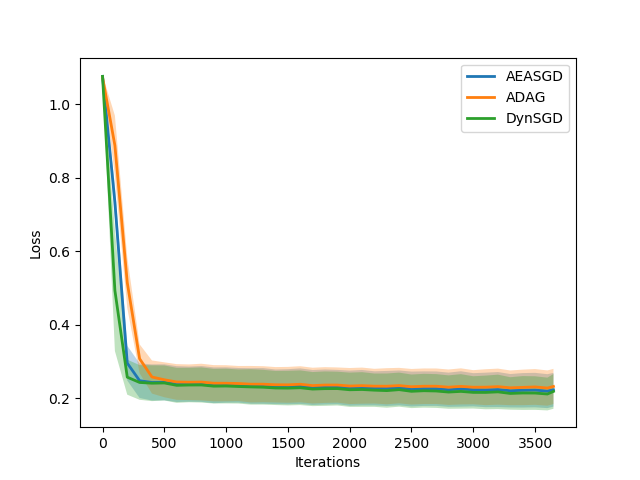

In [34]:
plt.figure()
plt.plot(x, y, lw=2, label='AEASGD')
plt.plot(x_adag, y_adag, lw=2, label='ADAG')
plt.plot(x_dsgd, y_dsgd, lw=2, label='DynSGD')
plt.fill_between(x, y - err , y + err, alpha=0.3)
plt.fill_between(x_adag, y_adag - err_adag,
                 y_adag + err_adag, alpha=0.3)
plt.fill_between(x_dsgd, y_dsgd - err_dsgd,
                 y_dsgd + err_dsgd, alpha=0.3)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Save the model

In [35]:
trained_model.save('trained_model.h5')

In [36]:
# as a test, laod the model and use the loaded model 
# to make predictions
from keras.models import load_model
loaded_model = load_model('trained_model.h5')

/afs/cern.ch/work/m/migliori/public/anaconda2/lib/python2.7/site-packages/keras/engine/saving.py:269: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


The model is compiled before the training inside each worker. (Just ignore the warnign)

### Make predictions

In [37]:
predictor = ModelPredictor(keras_model=loaded_model, features_col='features')
pred = predictor.predict(test).cache()

In [38]:
pred.select(['encoded_label', 'prediction']).show(5)

+-------------+--------------------+
|encoded_label|          prediction|
+-------------+--------------------+
|(3,[1],[1.0])|[0.00473992573097...|
|(3,[1],[1.0])|[0.00749076530337...|
|(3,[1],[1.0])|[0.00905921310186...|
|(3,[1],[1.0])|[0.00472246576100...|
|(3,[1],[1.0])|[0.00273628067225...|
+-------------+--------------------+
only showing top 5 rows



In [39]:
## Trigger the prediction
pred.count()

11788

## Random Forest

In [40]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(numTrees=50, maxDepth=10,
                            labelCol="label", predictionCol='prediction')

In [41]:
%time rf_model = rf.fit(train)

CPU times: user 148 ms, sys: 88.2 ms, total: 236 ms
Wall time: 49.1 s


In [42]:
pred_rf = rf_model.transform(test)

In [43]:
pred_rf.show(5)

+--------------------+-----+-------------+--------------------+--------------------+----------+
|            features|label|encoded_label|       rawPrediction|         probability|prediction|
+--------------------+-----+-------------+--------------------+--------------------+----------+
|[0.0,0.0027335674...|    1|(3,[1],[1.0])|[2.41843485846412...|[0.04836869716928...|       2.0|
|[0.0,0.0205177649...|    1|(3,[1],[1.0])|[2.70716415609991...|[0.05414328312199...|       2.0|
|[0.0,0.0340394724...|    1|(3,[1],[1.0])|[0.17683868275921...|[0.00353677365518...|       2.0|
|[0.0,0.0360913393...|    1|(3,[1],[1.0])|[0.16900747221949...|[0.00338014944438...|       2.0|
|[0.0,0.0371059290...|    1|(3,[1],[1.0])|[0.11651655834741...|[0.00233033116694...|       2.0|
+--------------------+-----+-------------+--------------------+--------------------+----------+
only showing top 5 rows



## Compute auc for the classes 

In [44]:
%%time
y_pred = np.asarray(pred.select('prediction').rdd\
                    .map(lambda row: np.asarray(row.prediction)).collect())
y_true = np.asarray(pred.select('encoded_label').rdd\
                    .map(lambda row: np.asarray(row.encoded_label)).collect())

CPU times: user 107 ms, sys: 15.6 ms, total: 123 ms
Wall time: 4.11 s


Let's try to do te same using pandas:

1. Convert Dense/Sparse vector to numpy arrays
2. Convert the dataframe to pandas

In [45]:
from pyspark.sql.types import ArrayType, DoubleType
from pyspark.sql.functions import udf
    
vector_udf = udf(lambda vector: vector.toArray().tolist(),ArrayType(DoubleType()))
pred = pred.select([vector_udf('encoded_label').alias('encoded_label'),
                    vector_udf('prediction').alias('prediction')])

In [46]:
pred.show(5)

+---------------+--------------------+
|  encoded_label|          prediction|
+---------------+--------------------+
|[0.0, 1.0, 0.0]|[0.00479354150593...|
|[0.0, 1.0, 0.0]|[0.02359892427921...|
|[0.0, 1.0, 0.0]|[0.00514733931049...|
|[0.0, 1.0, 0.0]|[0.00792555697262...|
|[0.0, 1.0, 0.0]|[0.00488353706896...|
+---------------+--------------------+
only showing top 5 rows



This should be very fast because we enabled `pyarrow` with 

```Python 
config("spark.sql.execution.arrow.enabled", "true")
```

In [47]:
%%time
pred_pd = pred.toPandas()

CPU times: user 55.9 ms, sys: 19.8 ms, total: 75.7 ms
Wall time: 2.29 s


In [48]:
pred_pd.head()

,encoded_label,prediction
0,"[0.0, 1.0, 0.0]","[0.004793541505932808, 0.01297409925609827, 0...."
1,"[0.0, 1.0, 0.0]","[0.02359892427921295, 0.02388577163219452, 0.9..."
2,"[0.0, 1.0, 0.0]","[0.0051473393104970455, 0.013156332075595856, ..."
3,"[0.0, 1.0, 0.0]","[0.007925556972622871, 0.01994471438229084, 0...."
4,"[0.0, 1.0, 0.0]","[0.004883537068963051, 0.021476557478308678, 0..."


In [49]:
y_true = np.array(pred_pd['encoded_label'].tolist())
y_pred = np.array(pred_pd['prediction'].tolist())

#### Collect  the prediction of the random forest

In [50]:
pred_rf = pred_rf.select([vector_udf('encoded_label').alias('encoded_label'),
                    vector_udf('probability').alias('probability')])

In [51]:
%time pred_rf_pd = pred_rf.toPandas()

CPU times: user 18.7 ms, sys: 4.63 ms, total: 23.3 ms
Wall time: 4.46 s


In [52]:
y_true_rf = np.array(pred_rf_pd['encoded_label'].tolist())
y_pred_rf = np.array(pred_rf_pd['probability'].tolist())

### Compute the auc
Finally, let's compute the auc for the different classifiers 

In [53]:
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()

fpr_rf = dict()
tpr_rf = dict()
roc_auc_rf = dict()

for i in range(3):
    #DNN
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    #RandomForest
    fpr_rf[i], tpr_rf[i], _ = roc_curve(y_true_rf[:, i], y_pred_rf[:, i])
    roc_auc_rf[i] = auc(fpr_rf[i], tpr_rf[i])

By applying a threshold requirement on $y_W$ or $y_{t\bar{t}}$, one can define a $W$ or $t\bar{t}$ classifier.

* label $QCD$ = 0
* label $t\bar{t}$ = 1
* label $W$ = 2

<IPython.core.display.Javascript object>


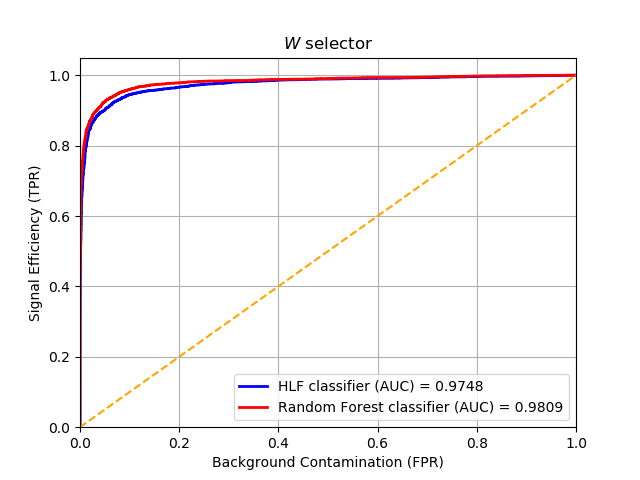

In [64]:
plt.figure()
plt.plot(fpr[1], tpr[1], color='blue',
         lw=2, label='HLF classifier (AUC) = %0.4f' % roc_auc[1])
plt.plot(fpr_rf[1], tpr_rf[1], color='red', 
         lw=2, label='Random Forest classifier (AUC) = %0.4f' % roc_auc_rf[1])
plt.plot([0, 1], [0, 1], color='orange', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Background Contamination (FPR)')
plt.ylabel('Signal Efficiency (TPR)')
plt.title('$W$ selector')
plt.legend(loc="lower right")
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


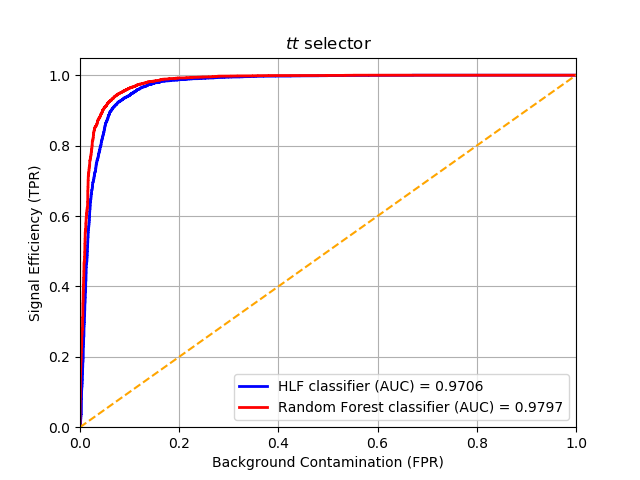

In [63]:
plt.figure()
plt.plot(fpr[2], tpr[2], color='blue',
         lw=2, label='HLF classifier (AUC) = %0.4f' % roc_auc[2])
plt.plot(fpr_rf[2], tpr_rf[2], color='red', 
         lw=2, label='Random Forest classifier (AUC) = %0.4f' % roc_auc_rf[2])
plt.plot([0, 1], [0, 1], color='orange', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Background Contamination (FPR)')
plt.ylabel('Signal Efficiency (TPR)')
plt.title('$tt$ selector')
plt.legend(loc="lower right")
plt.grid()
plt.show()

## Plot the confusion matrix

In [56]:
from sklearn.metrics import accuracy_score

print('Accuracy of the HLF classifier: {:.4f}'.format(
    accuracy_score(np.argmax(y_true, axis=1),np.argmax(y_pred, axis=1))))

Accuracy of the HLF classifier: 0.9205


<IPython.core.display.Javascript object>


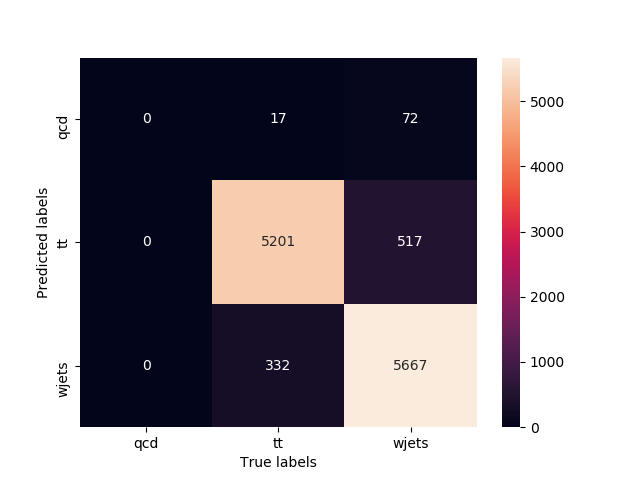

In [68]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
labels_name = ['qcd', 'tt', 'wjets']
labels = [0,1,2]

cm = confusion_matrix(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1), labels=labels)

fig, ax = plt.subplots()
ax = sns.heatmap(cm, annot=True, fmt='g')
ax.xaxis.set_ticklabels(labels_name)
ax.yaxis.set_ticklabels(labels_name)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [66]:
import pandas as pd

pd.value_counts(np.argmax(y_true, axis=1))

2    5999
1    5718
0      89
dtype: int64

## Elephas

With elephas we can use the same model used for distributed keras

In [239]:
model = Sequential()
model.add(Dense(50, input_shape=(14,), activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam')

In [240]:
from elephas.spark_model import SparkMLlibModel
from elephas.optimizers import Adam

In [260]:
spark_model = SparkMLlibModel(model=model, frequency='batch', mode='synchronous', 
                              elephas_optimizer=Adam(),
                              num_workers=8)

from collections import namedtuple
pData = namedtuple('pData', ['features', 'label'])

def map_record(record):
    row = pData(features=record.features, label=record.encoded_label)
    return row

dataRDD = train.select(['features', 'encoded_label']).rdd.map(lambda row: map_record(row))

In [261]:
%%time 
spark_model.fit(dataRDD, epochs=50, batch_size=128, verbose=1,
                validation_split=0.0, categorical=False, nb_classes=3)

CPU times: user 350 ms, sys: 13.4 ms, total: 363 ms
Wall time: 1min 32s


In [269]:
test_df = test.rdd.map(lambda row: (row.label, ) +
                       tuple(row.features.toArray().tolist())) \
                   .toDF(['label']).toPandas()
test_df.head()

,label,_2,_3,_4,_5,_6,_7,_8,_9,_10,_11,_12,_13,_14,_15
0,1,0.0,0.021942,0.456320,0.000426,0.0,0.0,0.038223,0.831326,0.319424,1.275692e-01,0.237893,0.000000,1.0,0.0
1,1,0.0,0.035063,0.485973,0.002071,0.0,0.0,0.011754,0.547480,0.136274,1.111329e-15,0.000000,0.000000,1.0,0.0
2,1,0.0,0.035322,0.096195,0.000232,0.0,0.0,0.010263,0.777020,0.193564,6.161629e-01,0.000000,0.293377,0.0,1.0
3,1,0.0,0.038613,0.681503,0.003885,0.0,0.0,0.041065,0.196172,0.298682,1.111329e-15,0.000000,0.180794,1.0,1.0
4,1,0.0,0.046474,0.358672,0.000861,0.0,0.0,0.007483,0.445514,0.532866,1.111329e-15,0.000000,0.000000,1.0,0.0


In [263]:
pred_elephas = spark_model.master_network.predict(test_df.iloc[:,1:])

In [264]:
y_true = np.asarray(test.select('encoded_label').rdd\
                    .map(lambda row: np.asarray(row.encoded_label)).collect())

In [265]:
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], pred_elephas[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [266]:
roc_auc

{0: 0.5932510988231958, 1: 0.6080410511959236, 2: 0.5948851367203363}

<IPython.core.display.Javascript object>


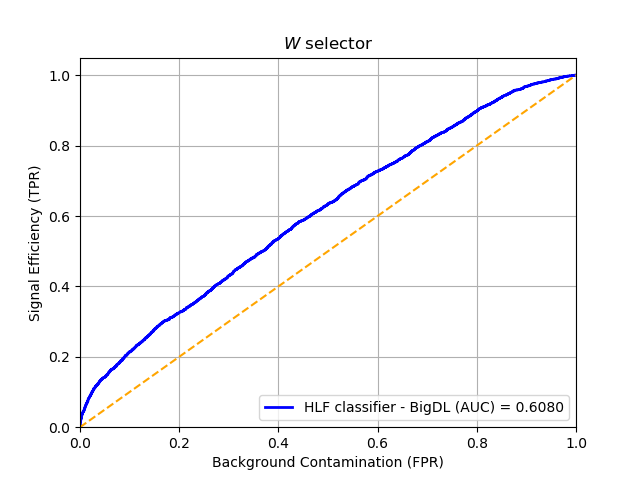

In [267]:
plt.figure()
plt.plot(fpr[1], tpr[1], color='blue',
         lw=2, label='HLF classifier - BigDL (AUC) = %0.4f' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='orange', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Background Contamination (FPR)')
plt.ylabel('Signal Efficiency (TPR)')
plt.title('$W$ selector')
plt.legend(loc="lower right")
plt.grid()
plt.show()

## BigDL

To run this notebook with BigDL you need to launch the following script (You cannot run the distriubuted keras part):

```Bash
export SPARK_HOME=/afs/cern.ch/work/m/migliori/public/spark2.3.1
export BIGDL_HOME=/afs/cern.ch/work/m/migliori/public/distributedDL/bigDL

export JAVA_HOME=/usr/lib/jvm/jre-openjdk

export PYSPARK_DRIVER_PYTHON=/afs/cern.ch/work/m/migliori/public/anaconda2/bin/jupyter

export PYSPARK_DRIVER_PYTHON_OPTS="notebook \
--NotebookApp.open_browser=False \
--NotebookApp.ip='0.0.0.0' \
--NotebookApp.port=8889"

${BIGDL_HOME}/bin/pyspark-with-bigdl.sh \
--master local[8] \
--driver-memory 15G
```

In [14]:
from bigdl.nn.layer import *
from bigdl.optim.optimizer import *
from bigdl.nn.criterion import *
from bigdl.util.common import *
from bigdl.nn.initialization_method import *

import numpy as np 

init_engine()

In [15]:
model = Sequential()
model.add(Linear(14,50))
model.add(ReLU())
model.add(Linear(50,20))
model.add(ReLU())
model.add(Linear(20,10))
model.add(ReLU())
model.add(Linear(10,3))
model.add(SoftMax())

creating: createSequential
creating: createLinear
creating: createReLU
creating: createLinear
creating: createReLU
creating: createLinear
creating: createReLU
creating: createLinear
creating: createSoftMax


In [17]:
trainRDD = train.rdd.map(lambda row: Sample.from_ndarray(np.array(row.features).flatten(),
                                                         np.array(row.label)+1))
testRDD = test.rdd.map(lambda row: Sample.from_ndarray(np.array(row.features).flatten(),
                                                         np.array(row.label)+1))

In [18]:
trainRDD.take(1)

[Sample: features: [JTensor: storage: [0.01388285 0.07797543 0.31642786 0.025384   0.1        0.
  0.03051309 0.368198   0.7118532  0.12340764 0.         0.
  0.         1.        ], shape: [14], float], labels: [JTensor: storage: [3.], shape: [1], float]]

In [19]:
import datetime as dt
num_epochs =  50
batch_size = 128

optimizer = Optimizer(model=model, 
                      training_rdd=trainRDD, 
                      criterion=CrossEntropyCriterion(),
                      optim_method=Adam(),
                      end_trigger=MaxEpoch(num_epochs),
                      batch_size=batch_size)

app_name = 'test-bdl-'+dt.datetime.now().strftime("%Y%m%d-%H%M%S")
train_summary = TrainSummary(log_dir='tmp/bigdl_summaries', app_name=app_name)
optimizer.set_train_summary(train_summary)

creating: createCrossEntropyCriterion
creating: createAdam
creating: createMaxEpoch
creating: createDistriOptimizer
creating: createTrainSummary


In [20]:
%time trained_model = optimizer.optimize()

CPU times: user 23.4 ms, sys: 26.8 ms, total: 50.2 ms
Wall time: 5min 1s


<IPython.core.display.Javascript object>


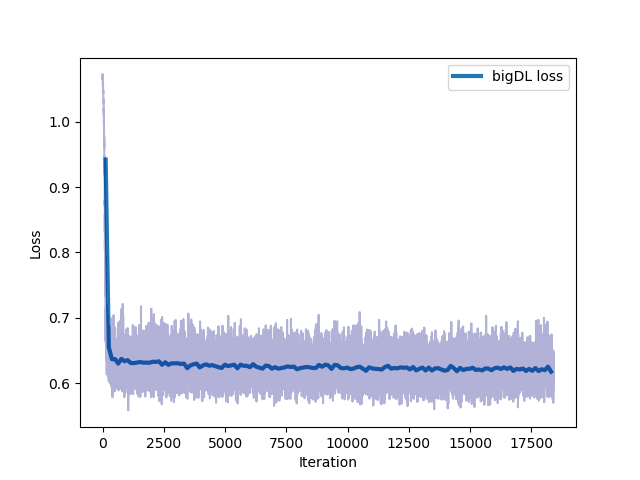

In [52]:
loss = np.array(train_summary.read_scalar("Loss"))

iteration = []
avg_loss = []
batch_loss = 0

for it, l in enumerate(loss[:,1]):
    batch_loss += l
    if (it%batch_size==0) and (it>0):
        avg_loss.append(batch_loss/batch_size)
        iteration.append(it)
        batch_loss = 0

plt.figure()
plt.plot(iteration, avg_loss, lw=3, label='bigDL loss')
plt.plot(loss[:,0], loss[:,1], alpha=0.3, color='navy')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()

You can also visualize the training with `tensorboard`:
   * `pip install jupyter-tensorboard`
   * After the installation type `jupyter tensorboard enable --user`
   * From the jupyter home, select the directory containing the logs and click on the botton `tensorboard`

In [25]:
pred = trained_model.predict(testRDD)

In [26]:
y_pred = np.asarray(pred.collect())
y_true = np.asarray(test.select('encoded_label').rdd\
                    .map(lambda row: np.asarray(row.encoded_label)).collect())

In [27]:
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [28]:
roc_auc

{0: 0.6767584141336593, 1: 0.9770448962322394, 2: 0.9740095247118836}

<IPython.core.display.Javascript object>


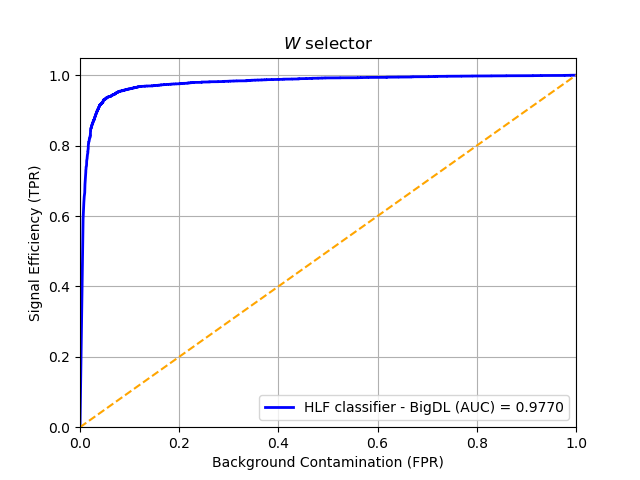

In [29]:
plt.figure()
plt.plot(fpr[1], tpr[1], color='blue',
         lw=2, label='HLF classifier - BigDL (AUC) = %0.4f' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='orange', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Background Contamination (FPR)')
plt.ylabel('Signal Efficiency (TPR)')
plt.title('$W$ selector')
plt.legend(loc="lower right")
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


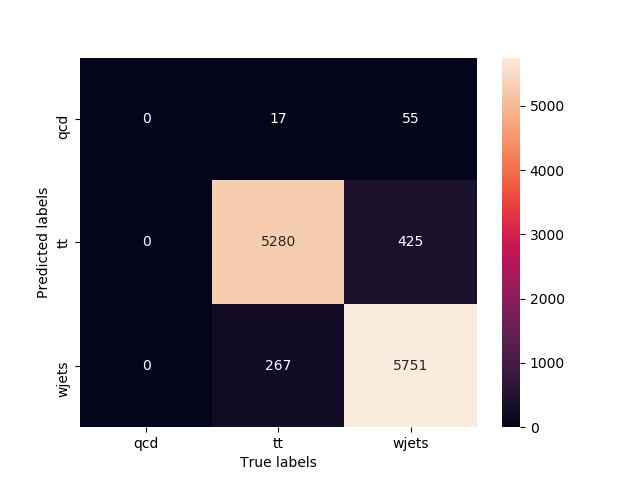

In [30]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
labels_name = ['qcd', 'tt', 'wjets']
labels = [0,1,2]

cm = confusion_matrix(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1), labels=labels)

fig, ax = plt.subplots()
ax = sns.heatmap(cm, annot=True, fmt='g')
ax.xaxis.set_ticklabels(labels_name)
ax.yaxis.set_ticklabels(labels_name)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()